# Lesson 3 — CNN Inference with a Pretrained Model 

## Goal

In this lesson, we use a **pretrained convolutional neural network (CNN)** to classify images. Our focus is entirely on **inference**, which means using an already trained model to make predictions on new data without modifying its learned parameters.

Conceptually, this lesson builds directly on the earlier example. The underlying mechanics remain the same: we perform a forward pass through a neural network, the model produces logits as raw outputs, and those *logits* are converted into meaningful predictions. What changes is not how the model thinks, but what it receives as input. Instead of small numerical vectors, the inputs are now full **images** with spatial structure.

We begin by clarifying what inference means in the context of deep learning and how it differs from training. With that foundation in place, we examine how convolutional neural networks process images and why pretrained models are especially effective for visual tasks. Finally, this lesson sets the stage for transfer learning, where an existing CNN can be adapted to new datasets and problem domains with minimal additional training.

---

## 1. Understanding Inference in Deep Learning

Inference refers to the stage where a trained model is used to make predictions on data it has never seen before. At this point, the model is no longer learning. Instead, it relies entirely on the patterns it learned during training. This distinction is important because most real-world uses of machine learning models involve inference rather than training.

During inference, the model performs only a forward pass. The input data flows through each layer of the network, transformations are applied, and an output is produced. Unlike training, no gradients are calculated and no weights are updated. This makes inference faster and more efficient, which is why trained models can be deployed in production systems such as web applications, mobile apps, or automated decision pipelines.

Understanding inference also helps clarify why pretrained models are useful. If a model has already learned strong visual features, we can immediately use it for prediction without repeating the expensive training process.

Before we run inference with a pretrained model, it is important to understand what a Convolutional Neural Network is and why it is especially effective for image data.

## Convolutional Neural Networks

A CNN is a type of **deep learning model** designed to automatically learn visual patterns from images. Unlike traditional machine learning models that rely on manually engineered features, CNNs learn these features directly from raw pixel values by passing the image through multiple layers that progressively extract more meaningful information.

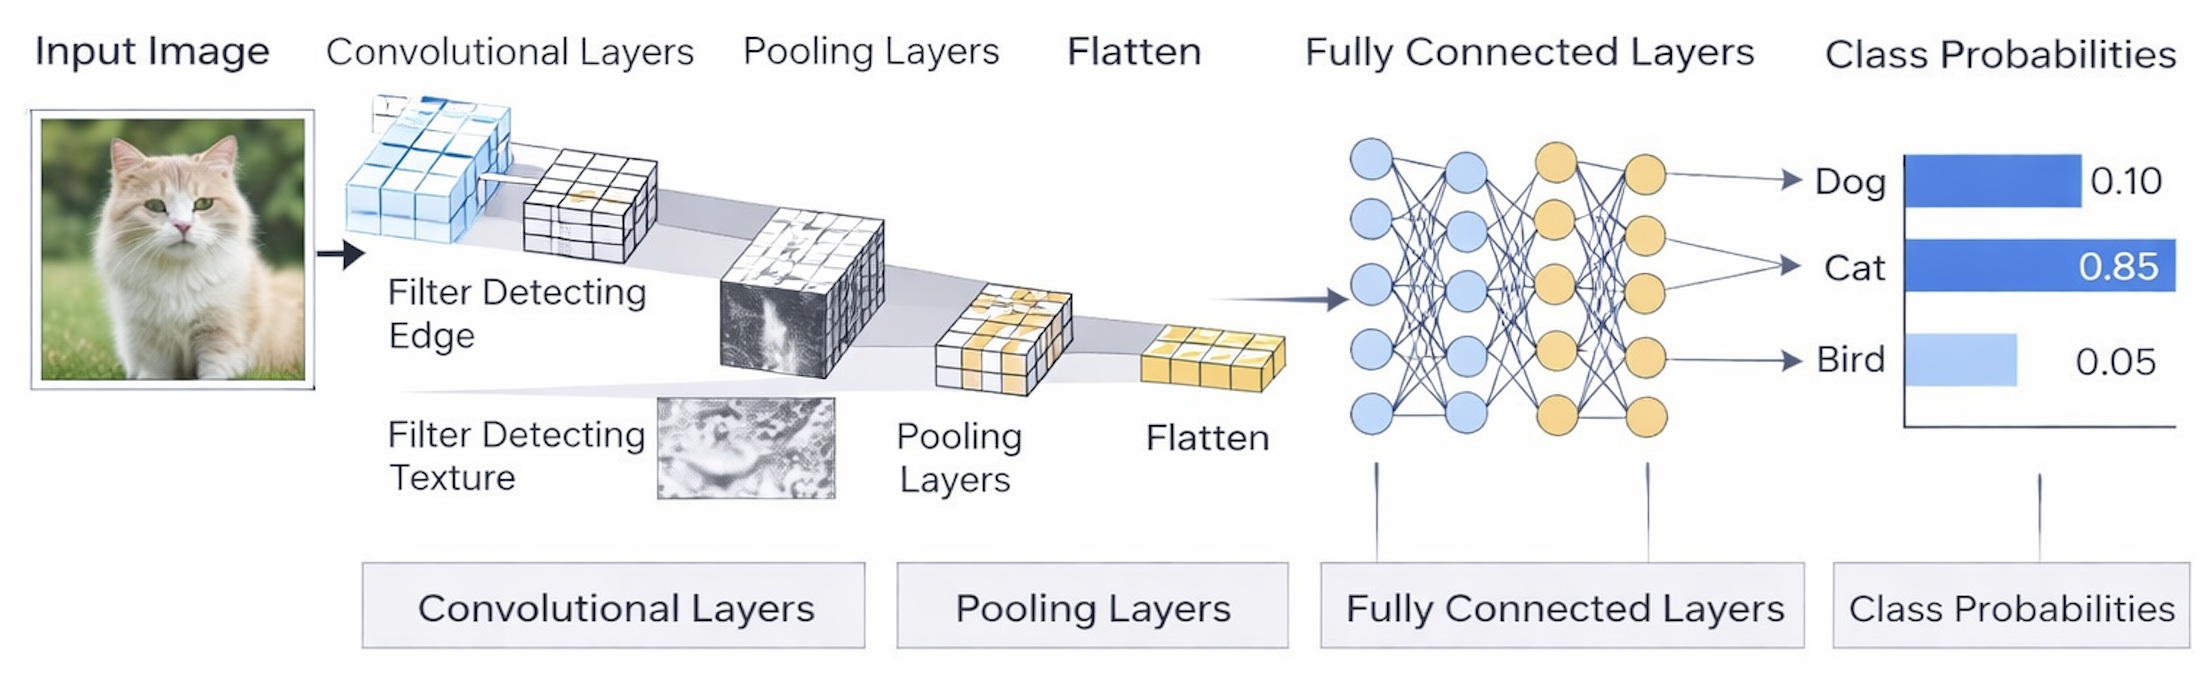

At a high level, a CNN takes an image as input and transforms it through a series of mathematical operations until it produces a final prediction. This process allows the model to recognize complex visual structures such as shapes, textures, and objects. The diagram above illustrates this transformation process step by step, showing how an input image moves through convolutional layers, pooling layers, and fully connected layers before producing class probabilities.

When an image is first given to a CNN, it exists simply as a grid of pixel values. On its own, this raw pixel data does not tell the model anything about edges, corners, or objects. The first convolutional layers solve this problem by applying small filters that slide across the image. These filters act as pattern detectors, responding strongly when they encounter specific visual features such as horizontal edges, vertical edges, or simple textures. As shown in the diagram, this operation converts the original image into feature maps that highlight where certain patterns appear.

After convolution, pooling layers reduce the spatial size of these feature maps. This step helps the network focus on the most important information while reducing computational complexity. Pooling also makes the model more robust to small changes in position, meaning that the network can still recognize an object even if it appears slightly shifted in the image. In the diagram, this is represented by feature maps becoming smaller while still preserving key visual information.

As the image passes through deeper convolutional layers, the features become increasingly abstract. Early layers may detect edges and simple shapes, while deeper layers combine these basic elements into more complex structures such as eyes, wheels, or textures. Eventually, the CNN builds a high-level representation of the image that captures its semantic meaning rather than just raw visual details.

Once these high-level features are extracted, they are passed into fully connected layers. These layers function similarly to a traditional neural network and use the learned features to make a final decision. The output of the network is a set of probabilities, where each value represents how confident the model is that the image belongs to a particular class. In the diagram, this is shown as class probabilities such as “Dog,” “Cat,” or “Bird,” with one class receiving the highest confidence score.

In the context of inference, all of these operations happen without any learning taking place. The CNN does not adjust its filters or weights during inference. Instead, it simply applies the patterns it learned during training to new, unseen images. This makes inference fast and efficient, which is why pretrained CNNs are commonly used in real-world applications such as image classification, facial recognition, medical imaging, and autonomous systems.

Understanding how CNNs process images helps explain why pretrained models are so powerful. A model trained on a large and diverse dataset has already learned rich and general visual features. When we use such a model for inference, we are leveraging years of training knowledge in a matter of seconds, allowing us to make accurate predictions without training a network from scratch.

If you’d like an additional intuitive explanation of how convolutional neural networks work, this guide presents the concepts in a very accessible way:
https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/

---

## 2. Setup

Now that we understand what inference is and how pretrained models work, we can start using them directly in code. PyTorch provides a companion library called TorchVision, which includes commonly used datasets, image transformations, and a collection of well-known pretrained CNN architectures. TorchVision allows us to load these models with just a few lines of code instead of implementing complex architectures from scratch.

If TorchVision is not already installed in your environment, it can be installed using the following command. Once installed, we can import the models module from TorchVision and access pretrained CNN models that are ready to use.


In [ ]:
pip install torchvision

The following imports provide the tools needed to load image data, work with pretrained neural networks, and visualize results.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

Choose CPU or GPU if available:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

---
## Common Pretrained CNN Architectures in TorchVision

TorchVision provides several well-known CNN architectures that were trained on large image datasets and are commonly used for image inference tasks.

Some architectures, like AlexNet and VGG, were among the earliest successful CNNs. They helped establish the idea that deep neural networks could learn visual features directly from raw images. However, these models tend to be large and computationally expensive, which makes them less practical today.

Other architectures, such as Inception and DenseNet, focus on improving feature reuse and efficiency. They introduce more complex connectivity patterns between layers, allowing the network to capture information at different scales. While powerful, these architectures can be harder to understand and modify for beginners.

There are also lightweight models like MobileNet, which are designed to run efficiently on devices with limited computational power, such as mobile phones or embedded systems. These models trade some accuracy for speed and efficiency.

Among these options, ResNet stands out as a strong balance between performance, simplicity, and reliability. It is widely used in practice, easy to load from TorchVision, and well-suited for inference tasks where we want accurate predictions without training a model from scratch.

With this context in mind, let’s take a closer look at the architecture we’ll be using in this notebook: **ResNet**.

## 3. What is ResNet?

**ResNet** (short for *Residual Network*) is a convolutional neural network architecture designed to train very deep models reliably. 

As neural networks grow deeper, they often face issues where performance stops improving or even degrades. ResNet addresses this problem by introducing residual connections, which allow information to skip certain layers and flow directly through the network. This helps preserve important features and makes deep networks easier to optimize.

The ResNet model used here was pretrained on ImageNet, a large-scale image dataset containing over a million images across 1,000 object categories. Through this training, the model has already learned general visual patterns such as edges, textures, shapes, and object structures. Instead of learning these features from scratch, we reuse this pretrained knowledge and apply the model directly for image inference.

---

## 4. Load a pretrained ResNet model

With an understanding of the ResNet architecture, the next step is to load a pretrained version of the model using TorchVision.

In the code below, we load ResNet-18, which is a lighter and faster variant of ResNet, making it well suited for inference and experimentation. The pretrained weights are automatically loaded from ImageNet, allowing the model to make meaningful predictions without any additional training. The model is then moved to the selected device, either a GPU or CPU, depending on availability. 

Finally, the model is set to evaluation mode. This step is important because it tells PyTorch that the model will only be used for inference. Certain layers behave differently during training and evaluation, and switching to evaluation mode ensures stable and correct predictions.


from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model = model.to(device)
model.eval()

---

## 5. ImageNet class labels

At this point, the model is fully initialized and ready to process input images.

Once the model produces an output, we need a way to interpret its predictions. The pretrained ResNet model outputs a vector of **1,000** values, where each value represents the model’s confidence score for a specific ImageNet category.

To make these outputs meaningful, we load the corresponding ImageNet class labels. Each position in the output vector maps directly to a human-readable category name, allowing us to translate raw numerical scores into understandable predictions such as dog, cat, or car. A full reference of these ImageNet categories is available here:

https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

It’s important to understand the limitation that comes with using a pretrained model. Because ResNet was trained only on the ImageNet dataset, it can recognize only these 1,000 predefined categories. If an image contains an object outside this label set, the model will still choose the closest match rather than identifying a new class.

This highlights a key trade-off when using pretrained networks: they are powerful and convenient for inference, but they are constrained by the data they were originally trained on. Supporting new or custom categories requires fine-tuning or training a model specifically for that task, which goes beyond simple inference.



To access these class names in code, TorchVision provides them directly through the pretrained model’s weight metadata. In the next cell, we retrieve the ImageNet category labels so that the model’s numerical predictions can be translated into human-readable class names.

In [ ]:
class_names = weights.meta["categories"]
len(class_names)

In [ ]:
class_names[110:130]

---

## 6. Image transforms (Torchvision v2)

Before we can pass images into a pretrained model, we need to make sure they are formatted exactly the way the model expects. Pretrained models like ResNet are trained on ImageNet images that follow a specific size, data type, and normalization scheme. If we skip this step or format images incorrectly, the model’s predictions will be unreliable, even if the code runs without errors.

TorchVision provides a set of image transformation utilities that help us prepare images correctly. In this notebook, we use the newer `torchvision.transforms.v2` API, which offers a cleaner and more consistent interface for preprocessing. These transformations handle resizing the image, converting it into a tensor, scaling pixel values, and normalizing the image using the same statistics that were used during ImageNet training.

The transformation pipeline defined below ensures that every input image matches the conditions under which the pretrained ResNet model learned to recognize objects. This alignment between training and inference data is critical for good performance.

In [ ]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

Now that our preprocessing pipeline is ready, the next step is to load actual images that we want the model to analyze.


---

## 7. Loading images from a folder

In real-world inference scenarios, images often come from files rather than datasets used during training. To keep things simple, we assume that all input images are stored in a single folder.

We assume images are stored in a folder like:

```
images/
  image1.jpg
  image2.jpg
  image3.jpg
```
Python’s `pathlib` module allows us to work with file paths in a clean and platform-independent way. Instead of manually listing image files, we can point to the folder and automatically collect all image paths inside it. This makes the inference pipeline flexible, since adding or removing images does not require changing the code.

In the next cell, we specify the image folder and gather all image file paths so they can be processed one by one.

In [ ]:
image_dir = Path("images")
image_paths = list(image_dir.glob("*"))

image_paths

---

## 8. Run inference on images

Once the images are loaded and transformed, we are ready to perform inference. Inference means passing input data through the model to obtain predictions, without updating any model weights. Since we are using a pretrained model only for prediction, the model is already set to evaluation mode, which ensures layers like dropout and batch normalization behave correctly.

For each image, we open it using the Python Imaging Library, apply the transformation pipeline, and move the resulting tensor to the same device as the model. This step is important because both the model and the data must be on the same device, whether that is the CPU or the GPU.

The transformed image is then passed through the model using a forward pass. The output is a vector of scores, one for each ImageNet category. These scores represent how strongly the model associates the image with each class. 

Inside the inference block, the model produces outputs called logits. These are raw, unnormalized scores for each ImageNet class. At this stage, they are not probabilities yet. We apply the softmax function immediately after to convert these scores into values that are easier to interpret. We will return to logits in more detail later in the lesson.

In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.inference_mode():
        logits = model(image_tensor)
        probs = torch.softmax(logits, dim=1)

    top_probs, top_idxs = probs.topk(5, dim=1)

    return image, top_probs.squeeze().cpu(), top_idxs.squeeze().cpu()

## 9. Visualize predictions

After defining how inference is performed for a single image, we now apply this logic to every image in our folder. Instead of manually selecting one image at a time, we loop through all available image paths and run inference on each one. This mirrors real-world inference pipelines, where models often process many inputs sequentially or in batches.

For each image, we retrieve the top predicted class labels along with their associated probabilities. To make the results easier to understand, we visualize both the input image and a bar chart showing the model’s top five predictions. This visual pairing helps students connect what the model sees with how confident it is in each prediction.

The following code ties together everything we have built so far: image loading, preprocessing, model inference, label decoding, and visualization.


In [ ]:
for image_path in image_paths:
    image, top_probs, top_idxs = predict_image(image_path)

    labels = [class_names[idx] for idx in top_idxs]
    probs = top_probs.tolist()  # convert tensor → list

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.barh(labels[::-1], probs[::-1])
    plt.xlabel("Probability")
    plt.title("Top 5 Predictions")

    plt.tight_layout()
    plt.show()

## 10. After the visualization output 

As we examine the predictions, it becomes clear that the model is very good at recognizing common objects such as animals, food, and everyday items. However, its behavior also reveals important limitations that come from how and what it was trained on.

This pretrained model was trained specifically for object recognition using the ImageNet dataset. When it encounters images that fall outside of its original training intent, such as people or unfamiliar concepts, it still tries to map them to the closest known categories. This explains why the model may focus on clothing, accessories, or background objects rather than identifying a person directly.

This observation reinforces an important idea: pretrained models are powerful, but they are not universal. Their predictions are constrained by the data and labels they were trained on.


---

## 11. What are logits?

Earlier, we briefly encountered logits during inference. Now let’s look at what they actually represent and why they matter.

When an image is passed through the network, the final layer outputs raw numerical values called **logits**. These values represent how strongly the model associates the image with each possible class, but they are not probabilities. Logits can be positive or negative, and their absolute values do not have an intuitive meaning on their own. What matters is how they compare relative to one another. To make these outputs easier to interpret, we apply the `softmax` function, which converts logits into probabilities that sum to one. This transformation allows us to say things like “the model is 70% confident this image belongs to a certain class.

It is important to understand that softmax does not change what the model believes. It simply reshapes the output into a more human-friendly form for interpretation and visualization.

---

In this lesson, we focused entirely on inference using a pretrained convolutional neural network. We loaded an already-trained ResNet model, prepared images in the correct format, and passed them through the network using a forward pass. We then converted the raw outputs into probabilities and visualized the model’s top predictions for each image.

Equally important is what we intentionally did not do. We did not train the model, modify its weights, or fine-tune it on new data. We also avoided using datasets, data loaders, or batch-based training logic. This was a deliberate choice to keep the focus on understanding inference as a standalone concept, separate from the complexity of training workflows.

This separation helps clarify the distinction between using a model and teaching a model.

---

## 12. Summary

In this lesson, you learned how to use a pretrained convolutional neural network (CNN) to perform image classification through inference alone. You saw how an input image flows through the model, produces logits, and is ultimately converted into meaningful predictions using class labels and probabilities. This workflow mirrors the same fundamental pattern you have seen before: input data goes into a model, the model produces numerical outputs, and those outputs are interpreted to make decisions.

Most importantly, you learned how to apply a powerful deep learning model without training it from scratch. This is how deep learning is often used in practice, especially when time, data, or computational resources are limited.

In the next lesson, we will build directly on this foundation. Instead of using the pretrained model as-is, we will learn how to adapt it to a new dataset using **Transfer Learning**. This will allow the model to move beyond its original ImageNet categories and learn to solve a new task more effectively.
